In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import time as t
from tqdm import trange

from pandas import DataFrame
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

import sklearn.metrics as mt
from sklearn.metrics import precision_recall_curve, classification_report

## I Read DATA from xlsx 

In [8]:
# read XLS Pandas - загрузка данных из исходного файла.
dataset = pd.read_excel('Dataset.xlsx', sheet_name='Исходные данные');
dataset.head()
# Осуществлен переход к следующему обозначению факторов модели плавки:
# Xi - факторы модели (процесса)

# Y - результирующий признак dataset['Удельные_потери'] 
print(dataset.columns)

Index(['Индекс', 'Номер партии', 'Номер партии_АСУТП', 'Номер плавки',
       'Номер рулона', 'Длина_1', 'Длина_2', 'Длина_3', 'Длина_4', 'Длина_5',
       ...
       'Водород_среднее', 'CO2_Этап2_зона5', 'H2_Этап2_зона5',
       'Точка_росы_Этап1_зона1', 'Точка_росы_Этап1_зона2', 'CO_Этап1_зона1',
       'CO_Этап1_зона2', 'H2_Этап1', 'CO2_Этап2_зона1', 'CO2_Этап2_зона3'],
      dtype='object', length=120)


In [13]:
# Размер
dataset.shape[0]
dataset['Удельные_потери'].head()

0    1.072
1    1.087
2    1.070
3    1.075
4    1.064
Name: Удельные_потери, dtype: float64

## II Инициализация данных + первичная обработка / фильтрация

In [16]:
# Исходный датафрейм факторов (параметров) модели
X0 = dataset.drop(['Удельные_потери'], axis=1) # все параметры за исключением результирующего
X0.head()

,Индекс,Номер партии,Номер партии_АСУТП,Номер плавки,Номер рулона,Длина_1,Длина_2,Длина_3,Длина_4,Длина_5,...,Водород_среднее,CO2_Этап2_зона5,H2_Этап2_зона5,Точка_росы_Этап1_зона1,Точка_росы_Этап1_зона2,CO_Этап1_зона1,CO_Этап1_зона2,H2_Этап1,CO2_Этап2_зона1,CO2_Этап2_зона3
0,0,522350,580797,1717428,70,23.28,2214.0,55.600000,5111.880000,121.760000,...,1.7,1.22,69.7,NaN,63.680000,NaN,1.6,69.75,0.1,0.06
1,1,522350,580797,1717428,70,25.22,2211.0,60.233333,5104.953333,131.906667,...,1.9,1.22,70.8,NaN,63.680000,NaN,1.6,69.75,0.1,0.06
2,2,522350,580797,1717428,70,27.16,2208.0,64.866667,5098.026667,142.053333,...,2.2,1.25,69.9,NaN,63.678693,NaN,1.6,69.75,0.1,0.06
3,3,522350,580797,1717428,70,29.10,2205.0,69.500000,5091.100000,152.200000,...,1.5,2.81,69.1,NaN,63.668600,NaN,1.6,69.75,0.1,0.06
4,4,522350,580797,1717428,70,31.04,2202.0,74.133333,5084.173333,162.346667,...,1.2,1.49,71.9,NaN,63.658507,NaN,1.6,69.75,0.1,0.06


### Особенности в данных 

In [31]:
# 1) Неполнота данных присутствует по следующим факторам
# (частичное или полное отсутсие данных)
X0['Поступление_в_технологическую_секцию']
X0['Выезд_из_технологической_секции']

X0['Начало непрерывного отжига']
X0['Окончание непрерывного отжига']

X0['Точка_росы_Этап1_зона1']
X0['Точка_росы_Этап1_зона2']

X0['CO_Этап1_зона1']

# 2) Все множество факторов имеет как количественное, так и качественное содержание
# 2.1) Качественные признаки
X0['ШОС']

# условно качественный может: быть преобразован в количественный или использоваться как класс
# качественного признака
X0['Толщина_перед_смоткой']

0                тренд 2,3
1                тренд 2,3
2                тренд 2,3
3                тренд 2,3
4                тренд 2,3
               ...        
12786    тредн2,3112691771
12787    тредн2,3084518828
12788    тредн2,3056345886
12789    тредн2,3028172943
12790             тредн2,3
Name: Толщина_перед_смоткой, Length: 12791, dtype: object

In [32]:
# Результирующий датафрейм выходного параметра модели - 'Удельные_потери'
Y0 = dataset[['Удельные_потери']]
Y0.head()

,Удельные_потери
0,1.072
1,1.087
2,1.070
3,1.075
4,1.064


In [333]:
# Первичная обработка данных (duplicates, null, not a number)
class FLTR:
    def __init__(self, mDupl, mNull, mNan, 
                       dfDupl_X0, dfNull_X0, dfNan_X0,
                       dfDupl_Y0, dfNull_Y0, dfNan_Y0,
                ):
        self.ObjDupl = mDupl
        self.ObjNull = mNull
        self.ObjNan = mNan
        self.Dupl_X0 = dfDupl_X0
        self.Null_X0 = dfNull_X0
        self.Nan_X0 = dfNan_X0
        self.Dupl_Y0 = dfDupl_Y0
        self.Null_Y0 = dfNull_Y0
        self.Nan_Y0 = dfNan_Y0

In [378]:
# Функция проверки датасетов на дубликаты, пустые и нечисловые строки, а также их чистка (при наличии)
def clrDataSet(D):
    
    # Словарь рез-ов
    mDict = {
        1: 'No duplicates',
        2: 'Duplicates deleted',
        3: 'No Null',
        4: 'Nulls deleted',
        5: 'No NaN',
        6: 'NaNs deleted'
    }
    
    D_dup = D.drop_duplicates() # исключение дубликатов
    D_null = D_dup.dropna(axis=1).dropna() # исключаем пустые поля (неполноу факторов) и пусты строки
   
    # исключение нечисловых строк
    num_df = (D.drop((D.columns[1:]), axis=1)
              .join(D_null[D_null.columns[1:]].apply(pd.to_numeric, errors='coerce')))
#     D_nan = num_df[D[D.columns[1:]].notnull().all(axis=1)]
    D_nan = num_df[num_df.notnull().values.any(axis=1)]
    
    if (D_dup.shape[0] == D.shape[0]):  # сравнение кол-ва строк исх. и очищенного датафрейма
        dp = 1
        mDupl = mDict[dp]
        dfDupl_X0 = None
        dfDupl_Y0 = None
    else:
        dp = 2
        # Переопределение факторов с учетом чистки
        X0 = D_dup.drop(D.columns[104:105], axis=1)
        Y0 = pd.DataFrame(D_dup['Удельные_потери'])
        mDupl = mDict[dp]
        dfDupl_X0 = X0[X0.columns[1:]]
        dfDupl_Y0 = Y0
        
    if (D_null.shape[0] == D.shape[0])&(D_null.shape[1] == D.shape[1]):
        dp = 3
        mNull = mDict[dp]
        dfNull_X0 = None
        dfNull_Y0 = None
    else:
        dp = 4
        # Переопределение факторов с учетом чистки
        X0 = D_null.drop(D.columns[104:105], axis=1)  
        Y0 = pd.DataFrame(D_null['Удельные_потери'])
        mNull = mDict[dp]
        dfNull_X0 = X0[X0.columns[1:]]
        dfNull_Y0 = Y0
    
    if (D_nan.shape[0] == D.shape[0])&(D_nan.shape[1] == D.shape[1]):
        dp = 5
        mNan = mDict[dp]
        dfNan_X0 = None
        dfNan_Y0 = None
    else:
        dp = 6
        # Переопределение факторов с учетом чистки
        X0 = D_nan.drop(D.columns[104:105], axis=1)
        Y0 = pd.DataFrame(D_nan['Удельные_потери'])
        mNan = mDict[dp]
        dfNan_X0 = X0[X0.columns[1:]]
        dfNan_Y0 = Y0
    
    return FLTR(mDupl, mNull, mNan, dfDupl_X0, dfNull_X0, dfNan_X0, dfDupl_Y0, dfNull_Y0, dfNan_Y0)

In [380]:
# Экземпляр объекта по очистке данных на предмет Dupl, Null, Nan
fltrObject = clrDataSet(dataset)

In [603]:
# Чистка данных
# ПРИМЕЧАНИЕ: для повышения достоверности и точности результатов моделирования необходимо в алгоритмах 
# также использовать различные методы интерполяции для критичных точек анализа, методы оценки однородности выборок 
# (исключение выборосов) и др.
fltrObject.ObjDupl, fltrObject.ObjNull, fltrObject.ObjNan

('No duplicates', 'Nulls deleted', 'NaNs deleted')

In [606]:
fltrObject.Dupl_X0, fltrObject.Dupl_Y0 # чистка дублей (они отсутствуют)

(None, None)

In [600]:
fltrObject.Null_X0.shape, fltrObject.Null_Y0.shape,\
fltrObject.Nan_X0.shape, fltrObject.Nan_Y0.shape,
# fltrObject.Nan_Y0

((12791, 110), (12791, 1), (12791, 110), (12791, 1))

## III Корреляция факторов модели 

In [599]:
# Переопределяем очищенный DF
dataset_clr_ = pd.concat([fltrObject.Nan_X0, fltrObject.Nan_Y0], axis=1, ignore_index=True)

new_cols = {idx: x for idx, x in enumerate(fltrObject.Nan_X0.columns)}
new_cols[dataset_clr_.shape[1]-1] = 'Удельные_потери'
dataset_clr = dataset_clr_.rename(columns=new_cols) 

# Корреляция факторов модели
CorrKoef = dataset_clr.corr()
CorrKoef_srt = CorrKoef.sort_values(by=['Удельные_потери'], ascending=False)['Удельные_потери']
sign_factors_val = pd.DataFrame(CorrKoef_srt[CorrKoef_srt>0.135])
sign_factors = pd.DataFrame(CorrKoef_srt[CorrKoef_srt>0.135]).index
sign_factors_val

,Удельные_потери
Удельные_потери,1.000000
Средние_магнитные_потери,0.797610
F,0.488820
Al,0.472760
Коэффициент_свойств_стали,0.447074
Cr,0.386131
Азот_среднее,0.370441
Азот_начало,0.274943
Азот_конец,0.273847
Толщина_МС,0.260606


In [598]:
# Для увеличения скорости обучения модели с несущественным падением точности можно исключить  
# Оставляем по коэф. корр. (>=|0.135|) - топ 20 параметров, которые оказывают влияние на результирующий признак - Y

# В итоге следует оставить:
# dataset_clr[sign_factors] для X и fltrObject.Nan_Y0 - для Y с поправкой на отсутствие более детальных техн. данных по объекту.

# Исходные матрицы для обучения и проверки адекватности рассматриваемого множества  моделей
X = dataset_clr[sign_factors] # входные параметры для обучения - Train и теста - Test
Y = fltrObject.Nan_Y0 # Целевые выходные значения - purpose - "Удельные_потери"
# X.head()
# Y.head()


## IV Формирование обучающей и тестовой выборок

In [515]:
Xtrn, Xtst, Ytrn, Ytst = train_test_split(X, Y, test_size=0.3)

In [596]:
Xtrn.shape, Xtst.shape, Ytrn.shape, Ytst.shape # проверка размерностей Train - Test

((8953, 20), (3838, 20), (8953, 1), (3838, 1))

### V Формирование списка базовых моделей для анализа объекта исследования 

In [597]:
# ЗАДАНИЕ СПИСКА МОДЕЛЕЙ
ModelList = [LinearRegression(), # МНК
             KNeighborsRegressor(n_neighbors=6), # метод ближайших соседей
             RandomForestRegressor(n_estimators=100, max_features ='sqrt'), # random forest
#              LogisticRegression(), # логистич. регр. - для задачи классификации
             SVR() # метод опорных векторов (default - ’rbf’)             
             ]
# В перспективе список моделей должен быть расширен в рамках
# единого алгоритма поиска наилучшего решения (по степени сложности и многопараметричности задачи). 
# Поиск найилучшей модели, необходимо осуществлять также с учетом оптимальной настройки каждой из используемых моделей.
# Также необходимо учитывать кодированные значения качественных признаков и физическую модель процесса плавки, 
# для уточнения (при ее наличии)

## VI Процедура выбора модели

In [517]:
# 1) Вариант 1 - Рассматривается процедура однокритериального поиска наилучшей модели по каждому в отдельности выходу,
# поскольку НЕ все модели из ModelList могут обучаться в режиме множественности выходов (в силу их специфики), 
# что требует доп. обработки на уровне кода
# 2) Для оценки производительности используется классический progressbar (вопросы повышения произв. модели, 
# как и её более точной настройки - отдельное исследование)
Y_cons = DataFrame()
TstModels = DataFrame() # Создание датафрейма для временного хранения структуры результатов (в виде табл) 
tmp = {} # Словарь используемых моделей: полного (с вх. параметрами) и краткого наименований

for m_i in (ModelList): # Проход по каждой модели
    
    m_str = str(m_i) # model name
    tmp['m_i'] = m_str[:m_str.index('(')] # Добавл. эл-в в словарь и Вывод наименования модели (без отображения настроечных параметров)      
    
    for j in  trange(Ytrn.shape[1]): # Проход по каждому рез. признаку
        #обучаем модель
        YYtrn = np.asarray(Ytrn.T[j:j+1].T).ravel()
        YYtst = np.asarray(Ytst.T[j:j+1].T).ravel()
        mif = m_i.fit(Xtrn, YYtrn) # аппроксимация данных / обучение модели
        mip = m_i.predict(Xtst)
        # Расчет коэф.детерм. - R2 как критерия поиска наилучшего решения
        tmp['R2_Y%s'%str(j+1)] = r2_score(YYtst, m_i.predict(Xtst))
        
        Y_cons = Y_cons.append([mip], ignore_index=True) # сохранение реультатов Y_i расчетов
        
    TstModels = TstModels.append([tmp])# Запись данных в датафрейм

TstModels.set_index('m_i', inplace=True) # индексация моделей по наименованию


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.91s/it]


In [595]:
TstModels # Численные результаты поиска наилучшей модели

,R2_Y1
m_i,
LinearRegression,1.000000
KNeighborsRegressor,0.916157
RandomForestRegressor,0.996736
SVR,-0.031550


In [594]:
# Дополнительный расчет регрессионной метрики - ошибки MSE (mean_squared_error)
MSE = np.zeros([len(ModelList),Ytst.shape[1]])

k = 0
for i in range(len(ModelList)):
    for j in range(Ytst.shape[1]):
        y = (Ytst.T[j:j+1].T)
        уm = Y_cons.T[k]
        k += 1
        MSE[i][j] = mt.mean_squared_error(y, уm) # Mean squared error regression loss
MSE      

array([[5.09006725e-31],
       [6.27921663e-03],
       [2.44478409e-04],
       [7.72553884e-02]])

In [520]:
# На основании анализа моделей по вых. результир. признаку Y ("Удельные_потери") 
# можно заключить, что модель № 1 и 3 наиболее точные (LinearRegression, RandomForestRegressor), что также подтверждается граф. анализом (см. ниже)
# По производительности это также не худший вариант (см. прогрессбары).

In [531]:
# для модели № 3 RandomForestRegressor можно оценить значимость каждого фактора для результир. признаков:
model3 = ModelList[2] # модель RandomForestRegressor
model3.fit(Xtrn, Ytrn['Удельные_потери'].ravel())

RandomForestRegressor(max_features='sqrt')

In [532]:
# X12, X31, X32, X52 (см. описание обозначений факторов выше)
model3.feature_importances_

array([0.45336608, 0.14383669, 0.0218932 , 0.01820159, 0.04186799,
       0.00372858, 0.035636  , 0.00903464, 0.0137488 , 0.06485665,
       0.06652561, 0.00898217, 0.01754992, 0.01005836, 0.00241721,
       0.00557696, 0.02376165, 0.02094263, 0.01759635, 0.02041893])

## VII Базовый Graph-анализ результатов

In [553]:
# Xtst[0:1]
# Ytst[0:1]

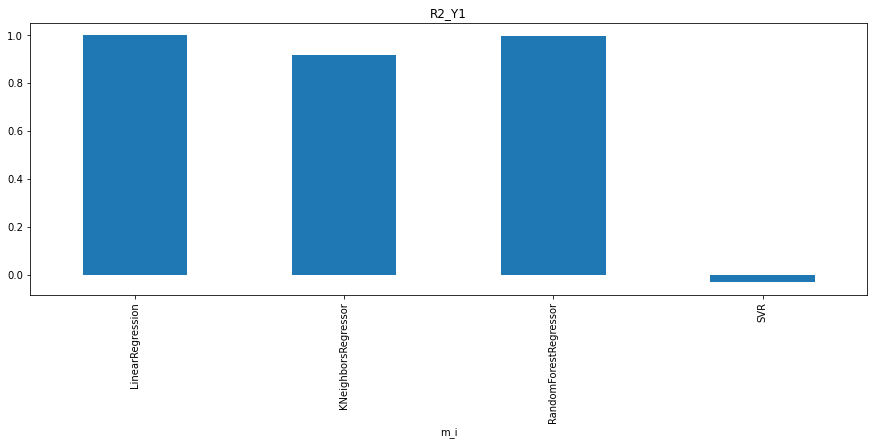

<Figure size 432x288 with 0 Axes>

In [593]:
# Graph 1 ***** ***** ***** ***** ***** ***** ***** 
# Анализ моделей в разрезе показтеля R2 
# Лучшим вариантом является модель № 1 и 3 (LR & RF), так как оцениваем изменение коэф. детерминации в пределах [0;1],
# несмотря на большие числа значения R2_Y1 для модели SVR
fig, axes = plt.subplots(ncols=1, figsize=(15,5))
TstModels.R2_Y1.plot(ax=axes, kind='bar', title='R2_Y1')
plt.show()
plt.clf()

In [555]:
# Числовое представление для Graph 1
dfR2 = pd.DataFrame(TstModels.R2_Y1) 
dfR2

,R2_Y1
m_i,
LinearRegression,1.000000
KNeighborsRegressor,0.916157
RandomForestRegressor,0.996736
SVR,-0.031550


In [556]:
# Формирование списка графиков для анализа Graph 2
ax_dict = {}
for j in range(len(ModelList)*Ytst.shape[1]): # кол-во моделей x количество выходов
    axi = 'ax%d' % (j+1)
    ax_dict[j] = str(axi)

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 174.21it/s]


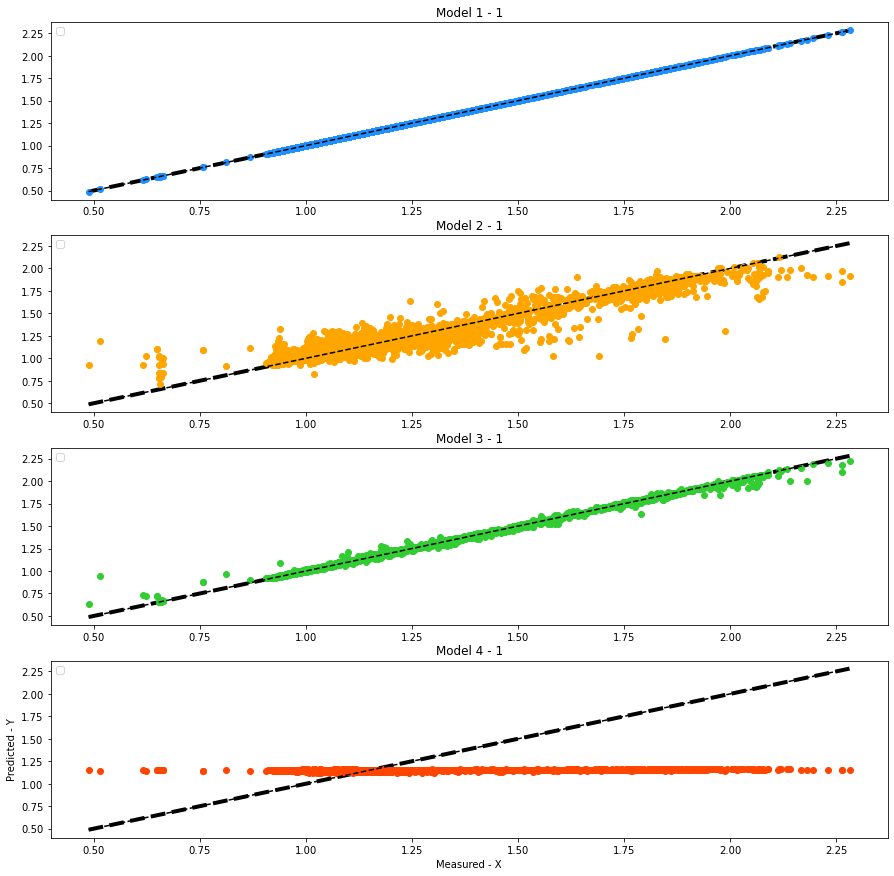

Graph building 0.3360004425048828  sec


<Figure size 432x288 with 0 Axes>

In [592]:
# Graph 2 ***** ***** ***** ***** ***** ***** ***** 
# 
# Ytst = np.asarray(Ytst.T[j:j+1].T).ravel()
# Xtst 

# fig, ax = plt.subplots(figsize=(5, 3))
import numpy as np
import matplotlib.pyplot as plt
#Ytst.shape[1]
fig, (axes) = plt.subplots(
    nrows=len(ModelList), ncols=Ytst.shape[1],
#     sharex = True, sharey = True,
    figsize=(15, 15)
    )

ax_dict  = axes.flatten()
p_color = ['#1e90ff', '#ffa500', '#32cd32', '#ff4500']

k=0 # коэф. итератора для влож объектов fig - axes
for i in trange(len(ModelList)):
    for j in range(Ytst.shape[1]):
        # постувеличение коэф. итератора
        ax = ax_dict[k]
        plt.grid(True, color='w', linestyle='-', linewidth=2)
        
#         уm = model3.predict(Xtst).T[j:j+1].T

        y = (Ytst.T[j:j+1].T)
        уm = Y_cons.T[k]
        
#         ax.scatter(y, уm, marker='o', c='r', edgecolor='b', lw=3) #marker='o', c='r', edgecolor='b' marker='o', c='r', edgecolor='b')
    #     ax.scatter(y, KNRpred1, edgecolors=(0, 0, 0))
    
        ax.set_title('Model %d - %d' % ((i+1), (j+1)))
        ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
        ax.plot(y, уm, 'bo', c=str(p_color[i]), lw=4)
        k += 1 
        ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--') # , lw=4
#         ax.legend(loc='upper left')
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, loc='upper left')
        
ax.set_xlabel('Measured - X')
ax.set_ylabel('Predicted - Y')

        
start_time = t.time()
plt.show()
print("Graph building", t.time() - start_time, " sec")
plt.clf()


In [105]:
# Из графиков выше видно, что разброс данных относительно идеального варианта (пунктирная линия) 
# меньше для модели № 1 и 3 (синий и зеленый цвет точек), что подтверждает выдвинутую ранее гипотезу